<a href="https://colab.research.google.com/github/AdrieonK/Bioinformatics-Data-Science/blob/main/physiochemical_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://archive.ics.uci.edu/static/public/265/physicochemical+properties+of+protein+tertiary+structure.zip

--2025-02-11 05:15:01--  https://archive.ics.uci.edu/static/public/265/physicochemical+properties+of+protein+tertiary+structure.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘physicochemical+properties+of+protein+tertiary+structure.zip.1’

physicochemical+pro     [ <=>                ]   3.37M  17.3MB/s    in 0.2s    

2025-02-11 05:15:01 (17.3 MB/s) - ‘physicochemical+properties+of+protein+tertiary+structure.zip.1’ saved [3528824]



In [2]:
!unzip '/content/physicochemical+properties+of+protein+tertiary+structure.zip'

Archive:  /content/physicochemical+properties+of+protein+tertiary+structure.zip
replace CASP.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: CASP.csv                


**Column Key**

RMSD-Size of the residue.
F1 - Total surface area.
F2 - Non polar exposed area.
F3 - Fractional area of exposed non polar residue.
F4 - Fractional area of exposed non polar part of residue.
F5 - Molecular mass weighted exposed area.
F6 - Average deviation from standard exposed area of residue.
F7 - Euclidian distance.
F8 - Secondary structure penalty.
F9 - Spacial Distribution constraints (N,K Value).

In [3]:
import pandas as pd
import numpy as np

In [4]:
casp_dataset = pd.read_csv('/content/CASP.csv')

casp_dataset.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


In [5]:
casp_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB


In [6]:
print(casp_dataset.columns)

Index(['RMSD', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9'], dtype='object')


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='RMSD'>

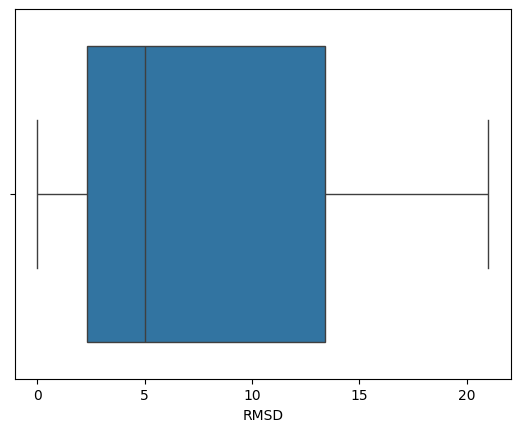

In [15]:
sns.boxplot(x=casp_dataset['RMSD'])

In [17]:
casp_features = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']

In [14]:
from sklearn.model_selection import train_test_split

In [18]:
X = casp_dataset[casp_features]
y = casp_dataset['RMSD']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, random_state = 1)

In [9]:
from sklearn.preprocessing import PowerTransformer

In [21]:
scaler = PowerTransformer()

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [27]:
rf_model = RandomForestRegressor(random_state = 1)

rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

initial_mae = mean_absolute_error(y_test, y_pred)

print(initial_mae)

2.8943180055944304


In [28]:
def get_mae_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf, X_train_scaled, X_test_scaled, y_train, y_test):
  rf_model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 1)

  rf_model.fit(X_train_scaled, y_train)

  rf_pred = rf_model.predict(X_test_scaled)

  mae = mean_absolute_error(y_test, rf_pred)

  return mae

In [29]:
best_mae = float('inf')
best_params = {}

In [33]:
n_estimators_list = [50, 100, 150]
max_depth_list = [None, 10, 20]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list =[1, 2, 4]

In [34]:
for n_estimators in n_estimators_list:
  for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
      for min_samples_leaf in min_samples_leaf_list:
        mae = get_mae_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf, X_train_scaled, X_test_scaled, y_train, y_test)
        if mae < best_mae:
          best_mae = mae
          best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

print("Best MAE:", best_mae)
print("Best Parameters:", best_params)

Best MAE: 2.8876601270743736
Best Parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [37]:
best_rf_model = RandomForestRegressor(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'], min_samples_leaf = best_params['min_samples_leaf'], random_state = 1)

best_rf_model.fit(X_train_scaled, y_train)

y_test_preds = best_rf_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_test_preds)

print(mae)


2.8876601270743736


Project Summary:
I worked on predicting RMSD (Root Mean Square Deviation) of protein tertiary structures using a dataset that includes physicochemical properties of these structures. The goal was to build a regression model that could predict RMSD based on features like total surface area, molecular mass weighted exposed area, and other properties related to the protein structures.

Steps Taken:
Data Exploration and Preprocessing:

I started by loading the dataset and performing some basic exploratory data analysis (EDA) using pandas and seaborn.
I visualized the RMSD distribution using a boxplot to check for any outliers.
After splitting the data into training and test sets, I applied PowerTransformer to scale the features.
Model Selection:

I chose RandomForestRegressor because it’s a robust model that can handle complex relationships and has built-in feature selection.
Model Evaluation:

I trained the model on the scaled training data and evaluated its performance using mean absolute error (MAE) on the test set. The initial MAE came out to be 2.8943.
Hyperparameter Tuning:

I did a grid search over various hyperparameters (n_estimators, max_depth, min_samples_split, and min_samples_leaf) to improve performance.
After tuning the hyperparameters, the MAE dropped slightly to 2.8877 on the test set.
Results:
The model's MAE improved marginally from 2.8943 to 2.8877 after tuning, showing a small but positive change in performance.
Key Takeaways:
Hyperparameter Tuning:

Even though the improvement was modest, hyperparameter tuning is critical for maximizing a model’s performance. It shows that carefully adjusting settings like the number of estimators and depth can lead to small but significant gains.
Model Performance:

The RandomForestRegressor performed reasonably well for this task, but since the improvements were minor, I think trying models like Gradient Boosting or XGBoost could potentially improve performance even further.
Feature Engineering:

The current model worked with the given features, but I think there’s room for improvement with more feature engineering, such as adding interaction terms or considering domain-specific features.
I could also try techniques like feature selection or PCA to help reduce noise and improve the model.
Outlier Handling:

While I did check for outliers visually in the RMSD feature using a boxplot, I could explore methods like RobustScaler or removing extreme outliers to improve model performance, especially if outliers are impacting the model's training.
Cross-Validation:

Instead of relying on just a single train-test split, I could use cross-validation to get a more robust estimate of model performance and reduce any bias that might come from that single split.
Next Steps:

Moving to RandomizedSearchCV could be a more efficient way of exploring hyperparameters rather than a full grid search.
I want to test different models, like Gradient Boosting or XGBoost, to see if they give better results.
Implementing cross-validation will give me a more reliable measure of model performance.
I’m also considering adding more or engineered features to see if that improves results.
Conclusion:
I’ve successfully built a model using Random Forest, and after tuning some hyperparameters, I saw a slight improvement in performance. While the improvements are modest, they suggest that the model is learning useful patterns from the data. I’m now looking into exploring different models, using cross-validation, and experimenting with feature engineering to push the model’s performance further.